# Analysis of Cell Technology
3 competing cell technologies may claim marketshare in future; Bifacial PERC, bifacial SHJ, and Bifacial TOPCon. Each design has different efficiency and a different silver intensity. This analysis seeks compare these technologies on a mass and energy basis. A psuedo global deployment projection hitting 100% RE targets in 2050 is used so that silver demand can be evaluated at the global level.

Make 4+ scenarios
1. All PERC
2. All SHJ
3. All TOPCon
4. Realistic blend / ITRPV numbers from Martin Springer or Jarett Zuboy – DURAMat tech scounting report
5. All of the above and turn Bifacial ON/OFF

We will use the silver intensity and module efficiency projections from:

    Zhang, Yuchao, Moonyong Kim, Li Wang, Pierre Verlinden, and Brett Hallam. 2021. “Design Considerations for Multi-Terawatt Scale Manufacturing of Existing and Future Photovoltaic Technologies: Challenges and Opportunities Related to Silver, Indium and Bismuth Consumption.” Energy & Environmental Science. https://doi.org/10.1039/D1EE01814K. 

and

    Gervais, Estelle, Shivenes Shammugam, Lorenz Friedrich, and Thomas Schlegl. 2021. “Raw Material Needs for the Large-Scale Deployment of Photovoltaics – Effects of Innovation-Driven Roadmaps on Material Constraints until 2050.” Renewable and Sustainable Energy Reviews 137 (March): 110589. https://doi.org/10.1016/j.rser.2020.110589.

In [1]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt

cwd = os.getcwd() #grabs current working directory

testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP' / 'CellTechCompare')
inputfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')
baselinesfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
supportMatfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')

if not os.path.exists(testfolder):
    os.makedirs(testfolder)

In [2]:
scennames = ['PERC','SHJ','TOPCon'] #add turn on/off bifacial
MATERIALS = ['glass','aluminium_frames','silver','silicon', 'copper', 'encapsulant', 'backsheet']
moduleFile_m = os.path.join(baselinesfolder, 'baseline_modules_mass_US.csv')
moduleFile_e = os.path.join(baselinesfolder, 'baseline_modules_energy.csv')

Bring in the data from Zhang et al 2021 and Gervais et al 2021.

In [92]:
lit_celltech = pd.read_excel(os.path.join(supportMatfolder,'PERCvSHJvTOPCon-LitData.xlsx'), sheet_name='Sheet2',
                             header=[0,1,2], index_col=0)

In [93]:
lit_celltech.columns.get_level_values

<bound method MultiIndex.get_level_values of MultiIndex([('Zhang et al 2021 (hallam)',   'PERC',  'ModuleEff'),
            ('Zhang et al 2021 (hallam)',   'PERC', 'Ag_mgpcell'),
            ('Zhang et al 2021 (hallam)',    'SHJ',  'ModuleEff'),
            ('Zhang et al 2021 (hallam)',    'SHJ', 'Ag_mgpcell'),
            ('Zhang et al 2021 (hallam)', 'TOPCon',  'ModuleEff'),
            ('Zhang et al 2021 (hallam)', 'TOPCon', 'Ag_mgpcell')],
           names=[None, None, 'year'])>

In [94]:
#Zhang et al Table 2 gives cell size assumptions 166mm cells
cell_size_m2 = np.square(0.166)

In [95]:
#calculate silver use per meter squared for each tech
zhang_perc_Ag_kgpm2 = lit_celltech['Zhang et al 2021 (hallam)']['PERC']['Ag_mgpcell']/1000/cell_size_m2 #creates series
zhang_shj_Ag_kgpm2 = lit_celltech['Zhang et al 2021 (hallam)']['SHJ']['Ag_mgpcell']/1000/cell_size_m2
zhang_topcon_Ag_kgpm2 = lit_celltech['Zhang et al 2021 (hallam)']['TOPCon']['Ag_mgpcell']/1000/cell_size_m2

Gervais et al 2021 also project silver use, but through 2050. We wil use Zhang et al silver intensity through 2030, then a futher decrease from Gervais et al to 2050. There is no projection of TOPCon from Gervais et al, so we will assume a similar magnitude of continued decrease.

In [96]:
lit_celltech.loc[2030]

                                   year      
Zhang et al 2021 (hallam)  PERC    ModuleEff     24.5
                                   Ag_mgpcell    57.0
                           SHJ     ModuleEff     25.3
                                   Ag_mgpcell    99.0
                           TOPCon  ModuleEff     25.0
                                   Ag_mgpcell    95.0
Name: 2030, dtype: float64

In [97]:
Gervais_perc_2050 = pd.Series({2050:40}) #mg/cell
Gervais_shj_2050 = pd.Series({2050:80}) #mg/cell
guess_topcon_2050 = pd.Series({2050:(95-18)}) # mg/cell 99-80 = 19, 57-40 = 17, guess further 18mg decrease
#assuming the same cell size as Zhang et al (it isn't specified in Gervais)
Gervais_perc_2050_kgpm2 = Gervais_perc_2050/1000/cell_size_m2
Gervais_shj_2050_kgpm2 = Gervais_shj_2050/1000/cell_size_m2
guess_topcon_2050_kgpm2 = guess_topcon_2050/1000/cell_size_m2

In [98]:
perc_Ag_kgpm2 = pd.concat([zhang_perc_Ag_kgpm2.loc[:2049], Gervais_perc_2050_kgpm2])
shj_Ag_kgpm2 = pd.concat([zhang_shj_Ag_kgpm2.loc[:2049], Gervais_shj_2050_kgpm2])
topcon_Ag_kgpm2 = pd.concat([zhang_topcon_Ag_kgpm2.loc[:2049], guess_topcon_2050_kgpm2])

In [99]:
#filled projections 2020 through 2050
perc_Ag_kgpm2.interpolate(inplace=True)
shj_Ag_kgpm2.interpolate(inplace=True)
topcon_Ag_kgpm2.interpolate(inplace=True)

Now lets use Zhang et al's projections of efficiency increases. These are reasonably ambitious, achieving ~25% by 2030, but PV is usually an overachiever. We will hold efficiency constant after 2030.

In [102]:
zhang_perc_modeff = lit_celltech['Zhang et al 2021 (hallam)']['PERC']['ModuleEff']
zhang_shj_modeff = lit_celltech['Zhang et al 2021 (hallam)']['SHJ']['ModuleEff']
zhang_topcon_modeff = lit_celltech['Zhang et al 2021 (hallam)']['TOPCon']['ModuleEff']

In [103]:
zhang_perc_modeff.interpolate(inplace=True)
zhang_shj_modeff.interpolate(inplace=True)
zhang_topcon_modeff.interpolate(inplace=True)

In [106]:
modeffs = pd.concat([zhang_perc_modeff,zhang_shj_modeff,zhang_topcon_modeff], axis=1)
modeffs.columns=['PERC','SHJ','TOPCon']
Aguse = pd.concat([perc_Ag_kgpm2,shj_Ag_kgpm2,topcon_Ag_kgpm2], axis=1)
Aguse.columns=['PERC','SHJ','TOPCon']

Text(0, 0.5, 'Module Efficiency [%]')

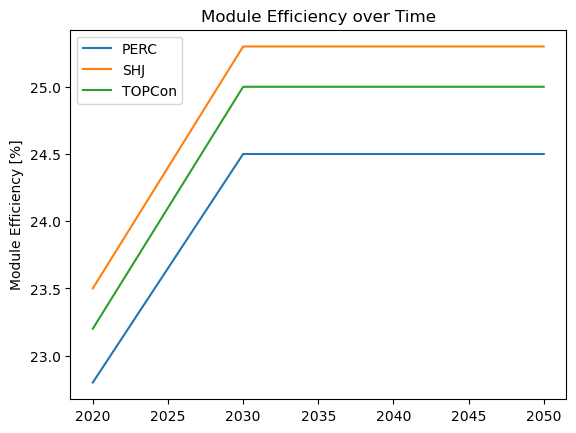

In [112]:
plt.plot(modeffs, label=modeffs.columns)
plt.legend()
plt.title('Module Efficiency over Time')
plt.ylabel('Module Efficiency [%]')

Text(0, 0.5, 'Silver Intensity [kg/m2]')

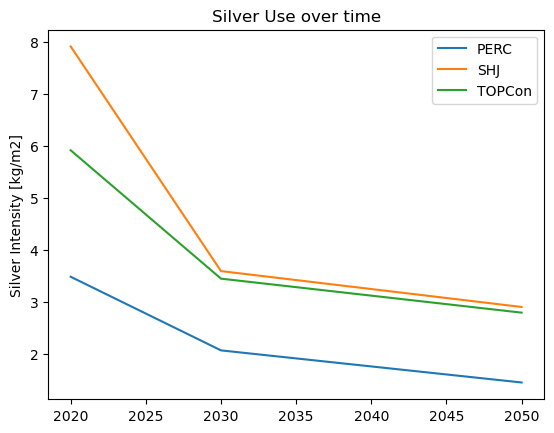

In [113]:
plt.plot(Aguse, label=Aguse.columns)
plt.legend()
plt.title('Silver Use over time')
plt.ylabel('Silver Intensity [kg/m2]')

One important aspect of these technologies is bifaciality. Each has a different bifaciality factor, and they are not expected to increase substantially with time (ITRPV 2022). We plan to explore monofacial and bifacial modules of these technologies (for example residential vs utility). We will use a static inventory of bifacial factors.

In [114]:
bifiFactors = {'PERC':0.7,
              'SHJ':0.9,
              'TOPCon':0.8} # ITRPV 2022, Fig. 58

To create a blended scenario, we will use the ITRPV 2022 cell market share projection through 2030, and then keep it constant through 2050.

In [ ]:
#insert data from Jarett here

Other Assumptions:
- silicon wafer thickness is identical, and improvements are identical
- module manufacturing energy is identical (until we get better data)
- degradation rates between the technologies are identical (until we get better data)
- Weibull Failure probabilities are identical between technologies (until we get better data)
- No ciruclarity

In [ ]:
#load in a baseline and materials for modification
sim1 = PV_ICE.Simulation(name='sim1', path=testfolder)
for scen in scennames:
    sim1.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
        for mat in range (0, len(MATERIALS)):
            matbaseline_m = r'..\baselines\baseline_material_mass_'+MATERIALS[mat]+'.csv'
            matbaseline_e = r'..\baselines\baseline_material_energy_'+MATERIALS[mat]+'.csv'
            sim1.scenario['USHistory'].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [ ]:
rtest = PV_ICE.Simulation(name='Sim1', path=inputfolder) #create fake simulation
rtest.createScenario(name='test', massmodulefile=r'..\baselines\baseline_modules_mass_US.csv') #create fake scenario, pull in module baseline
baseline = rtest.scenario['test'].dataIn_m #save baseline data as a seperate dataframe
baseline = baseline.drop(columns=['new_Installed_Capacity_[MW]']) #drop the installs column
baseline.set_index('year', inplace=True) #set index inplace to the year column
baseline.index = pd.PeriodIndex(baseline.index, freq='A')  # A -- Annual #inform the index that it is an annual period

In [ ]:
for scen in scennames:
    filetitle = scen+'.csv'
    subtestfolder = os.path.join(testfolder, 'Inputs')
    if not os.path.exists(subtestfolder):
        os.makedirs(subtestfolder)
    filetitle = os.path.join(subtestfolder, filetitle)

In [ ]:
#load in a baseline and materials for modification
r1 = PV_ICE.Simulation(name='sim1', path=testfolder)
r1.createScenario(name='USHistory', massmodulefile=moduleFile) #points at the old module history installs file
for mat in range (0, len(MATERIALS)):
    MATERIALBASELINE = r'..\baselines\baseline_material_mass_'+MATERIALS[mat]+'.csv'
    r1.scenario['USHistory'].addMaterial(MATERIALS[mat], massmatfile=MATERIALBASELINE)

In [ ]:
for scens in scennames:
    r1.scenario[scens].dataIn_m.loc[0:len(installs_df['year']-1),'new_Installed_Capacity_[MW]'] = installs_df[scens]